___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://img.freepik.com/free-photo/shop-clothing-clothes-shop-hanger-modern-shop-boutique_1150-8886.jpg" width="380px" height="200px" />


# <font color= #bbc28d> **Project 1 - Autoencoders** </font>
#### <font color= #2E9AFE> `Denoising Autoencoder`</font>

<br><br><br>
___

<p style="text-align:right; font-size:12px;" > Image retrieved from: "https://img.freepik.com/free-photo/shop-clothing-clothes-shop-hanger-modern-shop-boutique_1150-8886.jpg</p>

# <font color=#bbc28d> **Introduction** </font>
This notebook focuses on the implementation and training of a Denoising Autoencoder (DAE) applied to a catalog clothing image dataset. Unlike a standard autoencoder, a DAE is trained to reconstruct clean images from intentionally corrupted inputs, encouraging the model to learn robust and meaningful latent representations.

By learning to remove noise, the network captures the essential structure, textures, and visual patterns of garments instead of memorizing pixel-level details. This improves reconstruction quality and enhances generalization. The notebook covers the model architecture, noise injection process, training, and evaluation of reconstruction performance.

**`Note`**: Due to local hardware and storage limitations, all data cleaning and preprocessing steps in this notebook were executed using Google Colab.

In [ ]:
# Import general modules

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split

# <font color=#bbc28d> **Environment Preparation** </font>

Google Drive is mounted into the Google Colab environment. This allows the notebook to directly access files stored in cloud storage, such as datasets and preprocessed outputs.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Here we extract the compressed dataset archive stored in Google Drive into the Colab filesystem. This step makes the image files and metadata accessible for preprocessing without requiring repeated downloads.

In [ ]:
# Load normal images
X = np.load("/content/drive/MyDrive/processed/X_images.npy")

# Params used globally
IMG_SIZE = 256
BATCH_SIZE = 16
NOISE_FACTOR = 0.5
VAL_SPLIT = 0.1

# Size of normal images
print("Normal Images:", X.shape)

Normal Images: (2906, 256, 256, 3)


# <font color=#bbc28d> **Data Preparation** </font>

## <font color= #66b0b0>• **Dataset Splitting Strategy** </font>

In this section, we create a structured data split for training, validation, and testing.  
Instead of splitting the image array directly, we first generate an array of indices corresponding to each image. This approach ensures reproducibility and gives us full control over how samples are distributed across subsets.

The dataset is divided as follows:

- **Test set (10%)**: Held out for final model evaluation.
- **Training set**: Used to optimize model parameters.
- **Validation set**: Extracted from the training set to tune hyperparameters and monitor overfitting.

We shuffle the training indices before creating the validation split to ensure randomness and avoid any unintended ordering bias in the dataset. A fixed random seed is used to guarantee reproducibility of the results.

In [ ]:
# Array for index (0 -> size of our images (approx 3000))
indices = np.arange(len(X))

# Split index in tran/test
train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=42)

# Determine the size of the validation set
val_size = int(len(train_idx) * VAL_SPLIT)

# Shuffle index of the train so we have variation in train/val
np.random.seed(42)
np.random.shuffle(train_idx)

# Validation set
val_idx = train_idx[:val_size]

# Training set
train_idx = train_idx[val_size:]

## <font color= #66b0b0>• **Batch Generator with Noise Injection** </font>

This section defines a custom batch generator used to train the Denoising Autoencoder (DAE).  
Instead of feeding the entire dataset at once, we generate mini-batches during training. This approach is memory-efficient and allows us to inject noise on the fly.

For each batch:

- A subset of images is selected using pre-defined indices.
- Gaussian noise is added to the clean images to create corrupted inputs.
- The clean images remain as reconstruction targets.
- Optionally, pixel values are clipped to the valid range [0, 1].

The generator yields pairs of `(noisy_images, clean_images)`, where:
- **Input** → noisy images  
- **Target** → original clean images  

By regenerating noise at every iteration, the model learns to generalize better and becomes more robust to variations in the input data.

In [ ]:
def batch_generator(X_array, indices, batch_size=BATCH_SIZE, noise_factor=NOISE_FACTOR, clip=False):
    """
    Generator of noisy and clean  pair images for AE

    Args:
        X_array: Images you wish to create pairs for
        indices: index of the images to select
        batch_size: number of images per batch
        noise_factor: scale of the noise to add
        clip: clip scale of images [0,1]

    returns:
        X_noisy: batch of noisy images[input]
        X_batch: batch of clean images [target]
    """

    while True:
        # Shuffle indexes to randomize batches
        np.random.shuffle(indices)

        # Iterate over the index
        for start in range(0, len(indices), batch_size):
            batch_idx = indices[start:start+batch_size]  # Indexes of this batch round
            X_batch = X_array[batch_idx].astype(np.float32)  # Select those images from the dataset

            # Add Gaussian noise
            X_noisy = X_batch + noise_factor * np.random.normal(0.0, 1.0, X_batch.shape)

            # Clip values between [0,1]
            if clip:
                X_noisy = np.clip(X_noisy, 0.0, 1.0)

            yield X_noisy, X_batch

# Create training and validation generators
train_gen = batch_generator(X, train_idx)
val_gen   = batch_generator(X, val_idx)

# How many batches per epoch [training]
STEPS_PER_EPOCH = len(train_idx) // BATCH_SIZE

# Same but for val set
VAL_STEPS = len(val_idx) // BATCH_SIZE

We repeat the same process for the test dataset.

In [ ]:
def test_generator(X_array, batch_size=BATCH_SIZE, noise_factor=NOISE_FACTOR, clip=False):
  """
    Generator of noisy and clean  pair images for AE prediction

    Args:
        X_array: Images you wish to create pairs for
        batch_size: number of images per batch
        noise_factor: scale of the noise to add
        clip: clip scale of images [0,1]

    returns:
        X_noisy: batch of noisy images[input]
        X_batch: batch of clean images [target]
    """

  # Iterate for the whole test set
  for start in range(0, len(X_array), batch_size):
    batch_idx = np.arange(start, min(start+batch_size, len(X_array))) # Indexes of this batch round
    X_batch = X_array[batch_idx].astype(np.float32) # Select those images

    # Add Gaussian noise
    X_noisy = X_batch + noise_factor * np.random.normal(0.0, 1.0, X_batch.shape)

    # Clip values between [0,1]
    if clip:
        X_noisy = np.clip(X_noisy, 0.0, 1.0)

    yield X_noisy, X_batch


# <font color=#bbc28d> **DAE Models** </font>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

## <font color= #66b0b0>• **Model #1** </font>

### **Encoder**
- Convolutional layers with ReLU activation to extract spatial features.
- MaxPooling layers to progressively reduce spatial dimensions and create a compact representation.

This process forces the network to retain only the most relevant visual information.

### **Decoder**
- Convolutional layers refine feature maps.
- UpSampling layers restore spatial resolution.
- A final convolution with **sigmoid activation** ensures output pixel values remain in the range [0, 1].

### **Training Configuration**
The model is compiled using:
- **Adam optimizer** for efficient gradient-based optimization.
- **Mean Squared Error (MSE)** as the reconstruction loss, measuring pixel-wise differences between clean and reconstructed images.

This architecture enables the model to learn robust latent representations and reconstruct clean images from noisy inputs.

In [ ]:
# Encoder
input_img = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
encoded_simple = layers.MaxPooling2D(2, padding='same')(x)

# Decoder
x = layers.Conv2D(64, 3, padding='same', activation='relu')(encoded_simple)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.UpSampling2D(2)(x)
decoded_simple = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

autoencoder_simple_mse = models.Model(input_img, decoded_simple)
autoencoder_simple_mse.compile(optimizer='adam', loss='mse')
autoencoder_simple_mse.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Now, we train our model for 10 epochs

In [ ]:
EPOCHS = 10

history_simple_mse = autoencoder_simple_mse.fit(train_gen, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_gen, validation_steps=VAL_STEPS, epochs=EPOCHS)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - loss: 0.0339 - val_loss: 0.0045
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - loss: 0.0025 - val_loss: 0.0025


We save the model to be able to use it again without having to retrain it.

In [ ]:
# Save the full DAE
autoencoder_simple_mse.save("/content/drive/MyDrive/processed/Models/dae_simple_mse.keras")

### **Training and Validation Loss Analysis**

The graphic shows the reconstruction loss (MSE) for both training and validation sets across epochs.

We observe a sharp decrease in training loss during the first epochs, indicating that the model quickly learns meaningful feature representations. After this initial drop, both curves gradually stabilize.

This behavior suggests:

- Good generalization performance.
- No significant overfitting.
- Stable learning dynamics.

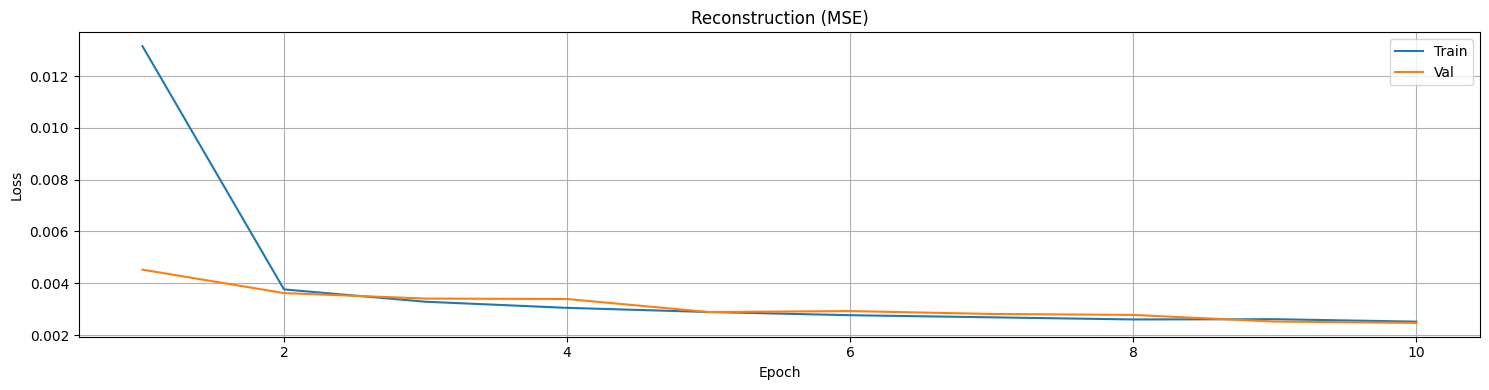

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

# Plot train and validation loss
ax.plot(epochs, history_simple_mse.history["loss"], label="Train")
ax.plot(epochs, history_simple_mse.history["val_loss"], label="Val")
ax.set_title("Reconstruction (MSE)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

### **Latent Space of the Denoising Autoencoder (MSE)**

This graph represents the two-dimensional projection of the latent space obtained with the model.

Each point corresponds to a sample from a subset, and its distribution shows how the model organizes images in a compressed space.  
The colors represent the original classes, making it possible to evaluate the model’s ability to separate categories in its latent representation.


In [ ]:
# Load saved model
autoencoder_mse = tf.keras.models.load_model(f"{path}/dae_simple_mse.keras")

In [ ]:
# Redefine with GlobalAveragePooling

try:
    latent_output_mse = autoencoder_mse.get_layer("latent").output
except:
    latent_output_mse = autoencoder_mse.layers[-2].output

pooled_output_mse = tf.keras.layers.GlobalAveragePooling2D()(latent_output_mse)
encoder_mse = tf.keras.Model(inputs=autoencoder_mse.input, outputs=pooled_output_mse)

In [ ]:
# Random sample
n_samples = 500
idx = np.random.choice(len(X), n_samples, replace=False)
X_sample = X[idx]
y_sample = y[idx]

with tf.device('/GPU:0'):
    latent_space_mse = encoder_mse.predict(X_sample, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
Shape reducido del espacio latente (MSE): (500, 32)


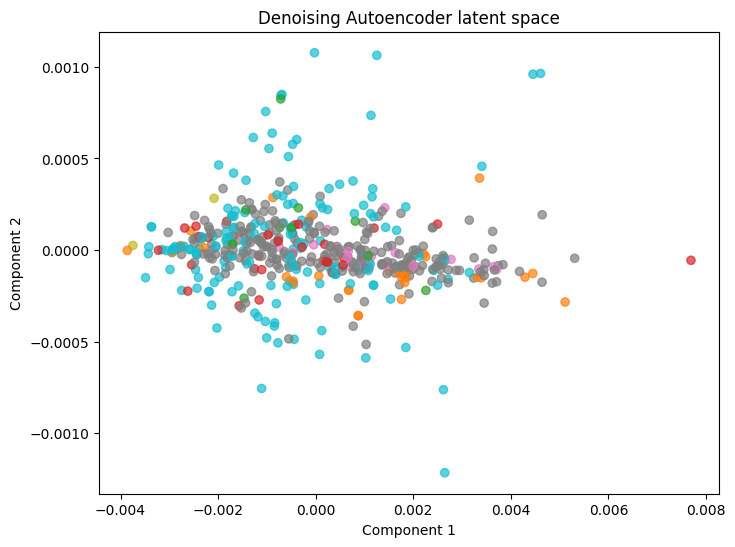

In [15]:
# Reduce to 2D with PCA
latent_2d_mse = PCA(n_components=2).fit_transform(latent_space_mse)

# -Graphic
plt.figure(figsize=(8,6))
plt.scatter(latent_2d_mse[:,0], latent_2d_mse[:,1], c=y_sample, cmap="tab10", alpha=0.7)
plt.title("Denoising Autoencoder latent space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


### **Generating Denoised Predictions on the Test Set**

Here we evaluate the trained Denoising Autoencoder on unseen test images.  
The goal is to generate reconstructed (denoised) versions of noisy inputs and store them for further analysis or visualization.

In [ ]:
# Predict and store denoised images
denoised_images = []

for X_noisy_batch, X_clean_batch in test_generator(X[test_idx], batch_size=BATCH_SIZE, noise_factor=NOISE_FACTOR):
    denoised_batch = autoencoder_simple_mse.predict(X_noisy_batch)
    denoised_images.append(denoised_batch)

denoised_images = np.concatenate(denoised_images, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


### **Visual Comparison: Original vs Noisy vs Denoised Images**

The figure above presents a qualitative evaluation of the Denoising Autoencoder’s performance.  
Each column shows three versions of the same image:

- **Original**: The clean original image.
- **Noisy**: The noisy input generated by adding Gaussian noise.
- **Denoised**: The reconstructed output generated by the trained autoencoder.

We observe that the model successfully removes a significant portion of the noise while preserving the overall structure, shape, and dominant colors of the garments. Although some fine-grained details and textures may appear slightly blurred, the reconstructed images retain the essential visual characteristics of the original items.

Overall, the results demonstrate that the model learned meaningful latent representations capable of recovering clean images from heavily corrupted inputs.

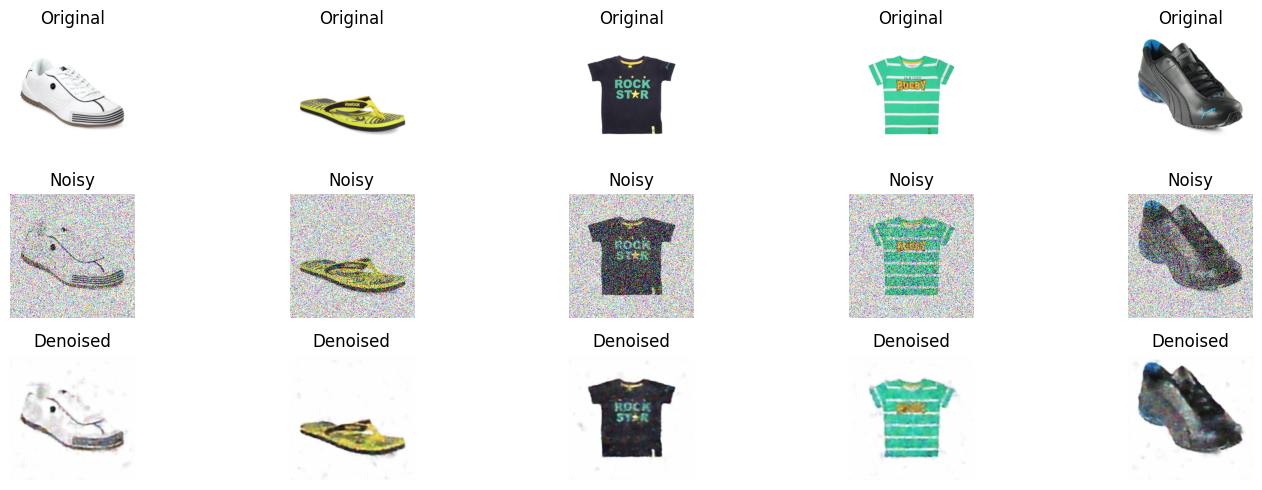

In [ ]:
def plot_denoising_results(X, denoised_images, test_idx, n=5, noise_factor=0.5, random_seed=42):
    """
    Plot noisy, denoised, and original images

    Args:
        X: Original images
        denoised_images: DAE predictions
        test_idx: indexes to sample from test
        n: number of images to plot
        noise_factor: scale of Gnoise to add
        random_seed: seed for numpy
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    indices_plot = np.random.choice(len(test_idx), n, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices_plot):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X[test_idx[idx]])
        plt.title("Original")
        plt.axis('off')

        # Noise
        ax = plt.subplot(3, n, i + 1 + n)
        noisy_img = np.clip(X[test_idx[idx]] + noise_factor * np.random.normal(0.0, 1.0, X[test_idx[idx]].shape), 0.0, 1.0)
        plt.imshow(noisy_img)
        plt.title("Noisy")
        plt.axis('off')

        # Prediction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised_images[idx])
        plt.title("Denoised")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_denoising_results(X, denoised_images, test_idx, n=5, noise_factor=NOISE_FACTOR, random_seed=42)

## <font color= #66b0b0>• **Model #2** </font>

### **Simple Denoising Autoencoder (MAE Loss)**

- The model takes noisy images as input.
- It learns to reconstruct the clean version of the images.
- We use **Mean Absolute Error (MAE)** as the loss function because it works well for image reconstruction tasks.
- The optimizer used is **Adam** for efficient training.

In [ ]:
autoencoder_simple_mae = models.Model(input_img, decoded_simple)
autoencoder_simple_mae.compile(optimizer='adam', loss='mae')
autoencoder_simple_mae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

We train the model for 10 epochs

In [ ]:
EPOCHS = 10

history_simple_mae = autoencoder_simple_mae.fit(train_gen, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_gen, validation_steps=VAL_STEPS, epochs=EPOCHS)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - loss: 0.0263 - val_loss: 0.0206
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - loss: 0.0198 - val_loss: 0.0190
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 0.0188 - val_loss: 0.0192
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - loss: 0.0188 - val_loss: 0.0185
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - loss: 0.0180 - val_loss: 0.0183
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - loss: 0.0195 - val_loss: 0.0179
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 0.0180 - val_loss: 0.0185
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - loss: 0.0179 - val_loss: 0.0185


In [ ]:
history_simple_mae = autoencoder_simple_mae.fit(train_gen, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_gen, validation_steps=VAL_STEPS, epochs=4)

Epoch 1/4
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 2/4
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - loss: 0.0174 - val_loss: 0.0181
Epoch 3/4
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 4/4
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 0.0174 - val_loss: 0.0222


We save the model to be able to use it later without having to train it again.

In [ ]:
# Save the full DAE
autoencoder_simple_mae.save("/content/drive/MyDrive/processed/Models/dae_simple_mae.keras")

### **Reconstruction Loss Visualization (MAE)**

This plot shows the training and validation loss over epochs. Here we can see that:

- Both training and validation loss decrease during the first epochs, indicating that the model is learning meaningful representations.
- After a few epochs, the losses stabilize around a similar low value.
- The training and validation curves remain close to each other, which suggests good generalization.
- There is no clear sign of overfitting, since validation loss does not increase significantly compared to training loss.

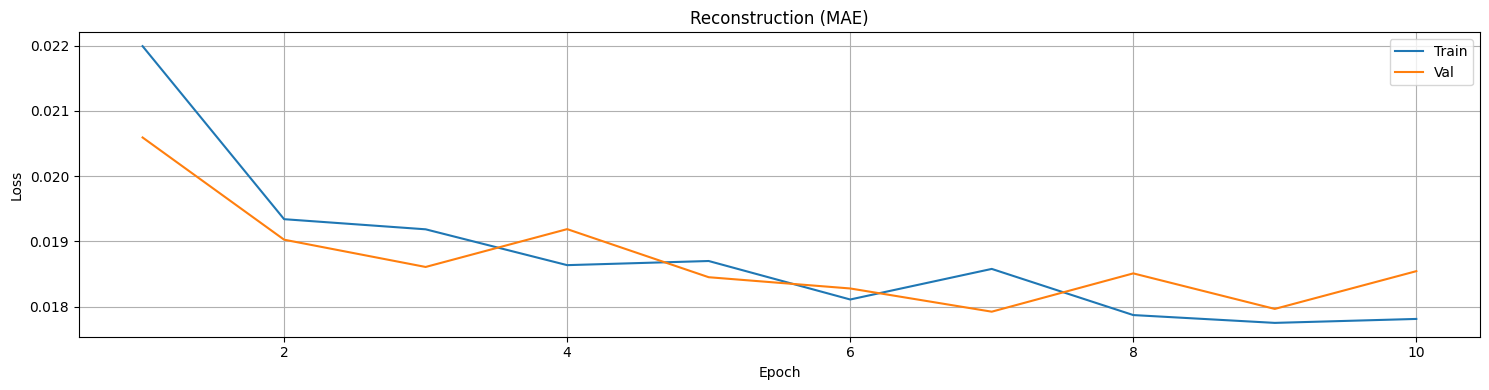

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

# Plot train and validation loss
ax.plot(epochs, history_simple_mae.history["loss"], label="Train")
ax.plot(epochs, history_simple_mae.history["val_loss"], label="Val")
ax.set_title("Reconstruction (MAE)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

### **Latent Space of the Denoising Autoencoder (MAE)**

This graph shows the two-dimensional projection of the latent space generated by the model.

Each point corresponds to an image, and its position reflects how the model organizes visual features in a compressed space.  
The colors indicate the original classes, this allows us to observe how well the model separates or overlaps categories in its latent representation.

Mounted at /content/drive
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Shape reducido del espacio latente: (500, 32)


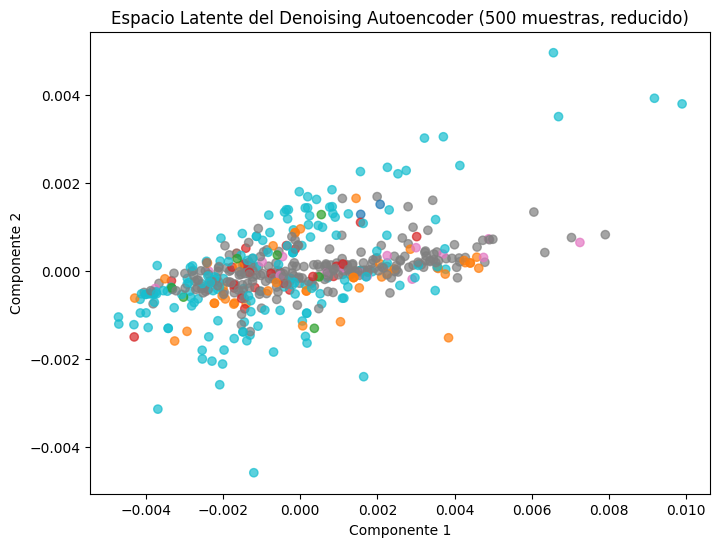

In [10]:
# Redefine encoder with GlobalAveragePooling
try:
    latent_output = autoencoder_simple_mae.get_layer("latent").output
except:
    latent_output = autoencoder_simple_mae.layers[-2].output

pooled_output = tf.keras.layers.GlobalAveragePooling2D()(latent_output)
encoder = tf.keras.Model(inputs=autoencoder_simple_mae.input, outputs=pooled_output)

# Random samples
n_samples = 500
idx = np.random.choice(len(X), n_samples, replace=False)
X_sample = X[idx]
y_sample = y[idx]

with tf.device('/GPU:0'):
    latent_space = encoder.predict(X_sample, batch_size=32, verbose=1)

# Reduce to 2D with PCA ---
latent_2d = PCA(n_components=2).fit_transform(latent_space)

# Graphic
plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=y_sample, cmap="tab10", alpha=0.7)
plt.title("Denoising Autoencoder latent space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


### **Generating Denoised Predictions on the Test Set**

Here we evaluate the trained Denoising Autoencoder on unseen test images.  
The goal is to generate reconstructed (denoised) versions of noisy inputs and store them for further analysis or visualization.

In [ ]:
# Predict and store denoised images
denoised_images = []

for X_noisy_batch, X_clean_batch in test_generator(X[test_idx], batch_size=BATCH_SIZE, noise_factor=NOISE_FACTOR):
    denoised_batch = autoencoder_simple_mae.predict(X_noisy_batch)
    denoised_images.append(denoised_batch)

denoised_images = np.concatenate(denoised_images, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


### **Visual Comparison: Original vs Noisy vs Denoised Images**

The figure above presents a qualitative evaluation of the Denoising Autoencoder’s performance.  
Each column shows three versions of the same image:

- **Original**: The clean original image.
- **Noisy**: The noisy input generated by adding Gaussian noise.
- **Denoised**: The reconstructed output generated by the trained autoencoder.


We can see that the results of this model are very simar to the first one.

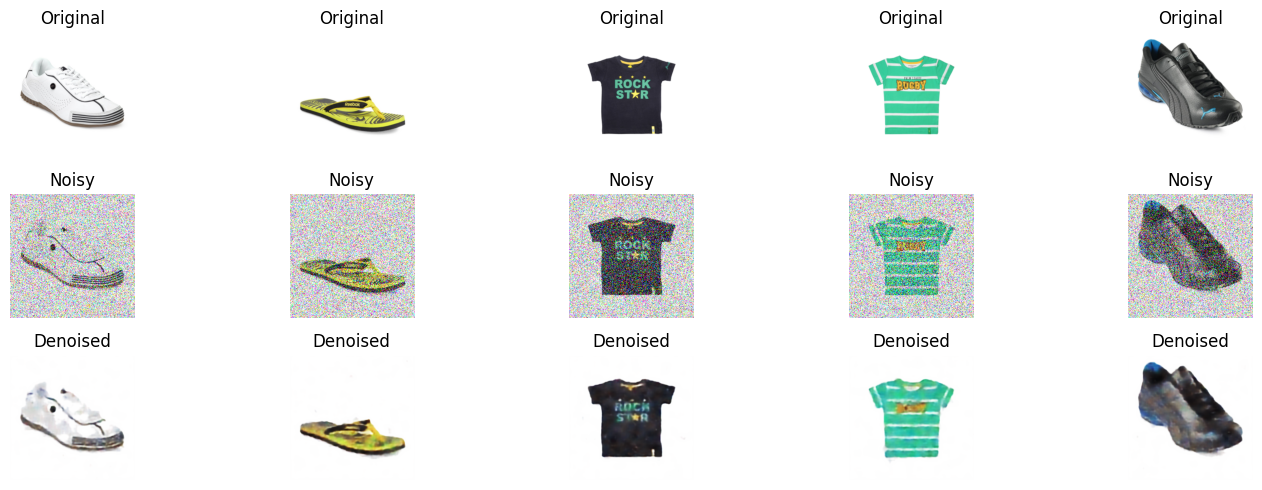

In [ ]:
plot_denoising_results(X, denoised_images, test_idx, n=5, noise_factor=NOISE_FACTOR, random_seed=42)

## <font color= #66b0b0>• **Model #3** </font>

The architecture of our third model consists of:

- **Encoder**: A stack of convolutional layers with Batch Normalization, ReLU activation, and MaxPooling to compress the image into a lower-dimensional latent representation.
- **Latent Space**: The compressed feature representation that captures the most important visual patterns.
- **Decoder**: A symmetric structure using convolutional layers and upsampling to reconstruct the original image from the encoded representation.

The model uses:
- `he_normal` initialization for better weight initialization in deep CNNs.
- `BatchNormalization` to stabilize and speed up training.
- `MSE (Mean Squared Error)` loss because this is a reconstruction problem.
- `Adam` optimizer for efficient gradient-based learning.
- `Sigmoid` activation in the output layer to generate pixel values between 0 and 1.

In [ ]:
input_img = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(input_img)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2, padding='same')(x)

x = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2, padding='same')(x)

x = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
encoded = layers.MaxPooling2D(2, padding='same')(x)

# Decoder
x = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(encoded)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D(2)(x)

x = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D(2)(x)

x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D(2)(x)

decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,335,043 (5.09 MB)

 Trainable params: 1,333,251 (5.09 MB)

 Non-trainable params: 1,792 (7.00 KB)

We train our model for 10 epochs

In [ ]:
EPOCHS = 10

history = autoencoder.fit(train_gen, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_gen, validation_steps=VAL_STEPS, epochs=EPOCHS)

Epoch 1/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 2/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 3/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - loss: 0.0032 - val_loss: 0.0068
Epoch 5/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - loss: 0.0031 - val_loss: 0.0036


We save the model to be able to use it later without having to re-train it again.

In [ ]:
# Save the full DAE
autoencoder.save("/content/drive/MyDrive/processed/Models/dse_complex_mse.keras")

### **Generating Denoised Predictions on the Test Set**

Here we evaluate the trained Denoising Autoencoder on unseen test images.  
The goal is to generate reconstructed (denoised) versions of noisy inputs and store them for further analysis or visualization.

In [ ]:
def test_generator(X_array, batch_size=BATCH_SIZE, noise_factor=NOISE_FACTOR):
    for start in range(0, len(X_array), batch_size):
        batch_idx = np.arange(start, min(start+batch_size, len(X_array)))
        X_batch = X_array[batch_idx].astype(np.float32)

        X_noisy = X_batch + noise_factor * np.random.normal(0.0, 1.0, X_batch.shape)
        #X_noisy = np.clip(X_noisy, 0.0, 1.0)

        yield X_noisy, X_batch

# Predict and store denoised images
denoised_images = []

for X_noisy_batch, X_clean_batch in test_generator(X[test_idx], batch_size=BATCH_SIZE, noise_factor=NOISE_FACTOR):
    denoised_batch = autoencoder.predict(X_noisy_batch)
    denoised_images.append(denoised_batch)

denoised_images = np.concatenate(denoised_images, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

Reload the model that we had previously saved

In [ ]:
from tensorflow.keras.models import load_model

autoencoder2 = load_model("/content/drive/MyDrive/processed/Models/dse_complex_mse.keras")

### **Visual Comparison: Original vs Noisy vs Denoised Images**

The figure above presents a qualitative evaluation of the Denoising Autoencoder’s performance.  
Each column shows three versions of the same image:

- **Original**: The clean original image.
- **Noisy**: The noisy input generated by adding Gaussian noise.
- **Denoised**: The reconstructed output generated by the trained autoencoder.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_denoising_results(X, denoised_images, test_idx, n=5, noise_factor=0.5, random_seed=None):
    """
    Plot noisy, denoised, and original images in a 3-row grid.

    Args:
        X: np.array of original images.
        denoised_images: np.array of autoencoder predictions.
        test_idx: list/array of indices to sample from X.
        n: number of images to plot.
        noise_factor: scale of Gaussian noise to add.
        random_seed: optional, for reproducibility.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    indices_plot = np.random.choice(len(test_idx), n, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices_plot):
        # Noisy
        ax = plt.subplot(3, n, i + 1)
        noisy_img = np.clip(
            X[test_idx[idx]] + noise_factor * np.random.normal(0.0, 1.0, X[test_idx[idx]].shape),
            0.0, 1.0
        )
        plt.imshow(noisy_img)
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[idx])
        plt.title("Denoised")
        plt.axis('off')

        # Original
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(X[test_idx[idx]])
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_denoising_results(X, denoised_images, test_idx, n=5, noise_factor=NOISE_FACTOR, random_seed=42)

In this visualization, we can see that the DAE removes the noise from the images pretty well, but it doesn't have a significantly higher performance than the two previous models that had ~1.2M less parameters.



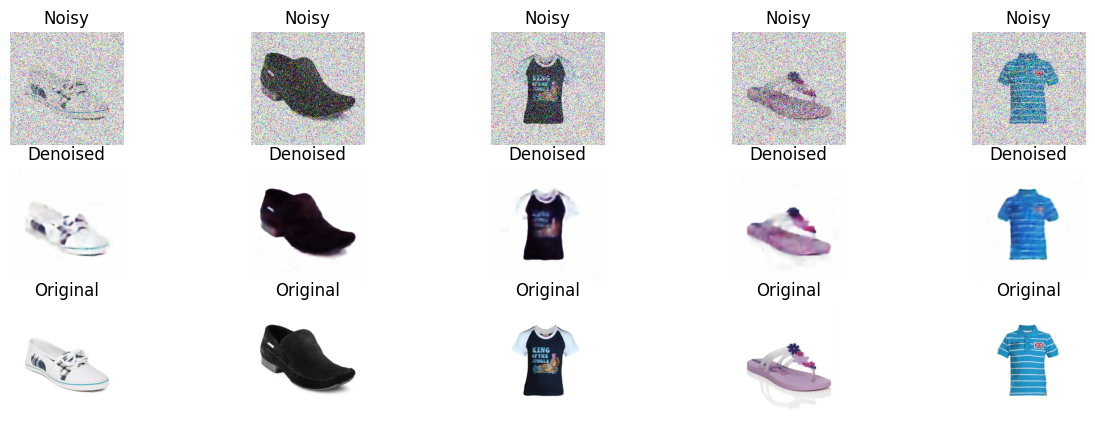

In [ ]:
n = 5
indices_plot = np.random.choice(len(test_idx), n, replace=False)

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices_plot):
    # Noisy
    ax = plt.subplot(3, n, i+1)
    noisy_img = np.clip(X[test_idx[idx]] + NOISE_FACTOR * np.random.normal(0.0, 1.0, X[test_idx[idx]].shape), 0.0, 1.0)
    plt.imshow(noisy_img)
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(denoised_images[idx])
    plt.title("Denoised")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(X[test_idx[idx]])
    plt.title("Original")
    plt.axis('off')
plt.show()

In [ ]:
test_input = np.expand_dims(X[test_idx[0]], axis=0)
print("Min/Max input:", test_input.min(), test_input.max())
pred = autoencoder.predict(test_input)
print("Min/Max output:", pred.min(), pred.max())

Min/Max input: 0.1254902 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Min/Max output: 0.9999988 1.0


# <font color=#bbc28d> **Conclusion** </font>

As part of this project, we trained three different autoencoder architectures for the denoising task.

Two lightweight models with approximately ~75,000 parameters each achieved strong reconstruction performance, effectively removing noise while preserving the most important visual details. Their relatively small size makes them computationally efficient and suitable for practical deployment.

A third, significantly larger model with more than 1 million parameters was also trained. However, its performance was comparable to the smaller models, without significant improvements in reconstruction quality.

These results suggest that increasing model complexity does not necessarily lead to better performance for this task. In this case, the simpler architectures provide an optimal balance between efficiency and reconstruction quality.